In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

## Preparação do Dataset

⚠️ Reshape porque implementaremos a MLP usando operações matriciais. 

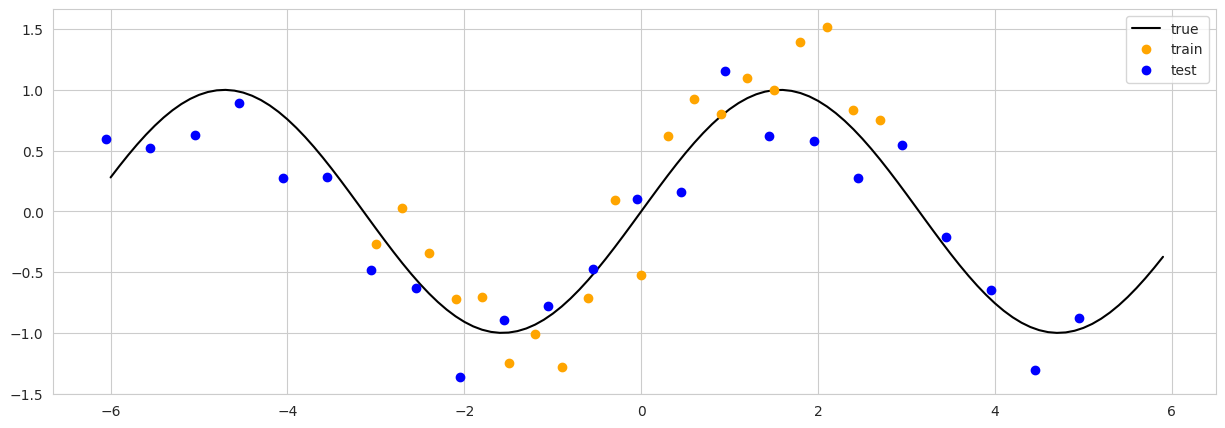

In [8]:
all_x = np.arange(-6.0, 6.0, 0.1)
train_x = np.arange(-3, 3, 0.3)
test_x = np.arange(-6.05, 5.06, 0.5)

all_x = all_x.reshape((len(all_x), 1, 1))
train_x = train_x.reshape((len(train_x), 1, 1))
test_x = test_x.reshape((len(test_x), 1, 1))

train_y = np.sin(train_x) + np.random.normal(size=train_x.shape) * 0.3
test_y = np.sin(test_x) + np.random.normal(size=test_x.shape) * 0.3

plt.close('all')
plt.figure(figsize=(15,5))
plt.plot(all_x.squeeze(), np.sin(all_x).squeeze(), '-', color='black', label='true')
plt.plot(train_x.squeeze(), train_y.squeeze(), 'o', color='orange', label='train')
plt.plot(test_x.squeeze(), test_y.squeeze(), 'o', color='blue', label='test')
plt.legend()
plt.show()

## Implementação da MLP - Versão mais Simples

### Funções de Ativação e Suas Derivadas

In [9]:
import numpy as np

def sigmoid(x):
    """
    Função sigmoid: sigma(x) = 1 / (1 + exp(-x))
    Pode ser usada com escalares, vetores ou matrizes NumPy.
    """
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def tanh_grad(x):
    return 1 - np.square(np.tanh(x))

def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    return (x > 0).astype(x.dtype)

### MLP


In [10]:

class Mlp:
    def __init__(self, activation_fn, activation_grad_fn, n_hidden):
        self._activation_fn = activation_fn
        self._activation_grad_fn = activation_grad_fn
        self._n_hidden = n_hidden
        self.reset()

    def reset(self):
        """Reinicia os parametros para valores aleatorios"""
        self._w0 = np.random.normal(size=(self._n_hidden, 1))
        self._b0 = np.random.normal(size=(self._n_hidden, 1))
        self._w1 = np.random.normal(size=(1, self._n_hidden))
        self._b1 = np.random.normal(size=(1, 1))

    def zero_grad(self):
        """Reseta os gradientes para zero"""
        self._grad_w0 = np.zeros_like(self._w0)
        self._grad_b0 = np.zeros_like(self._b0)
        self._grad_w1 = np.zeros_like(self._w1)
        self._grad_b1 = np.zeros_like(self._b1)

    def forward(self, x):
        """Calcula a saida da rede para uma dada entrada"""
        # first layer
        self._z0 = np.matmul(self._w0, x) + self._b0
        self._h0 = self._activation_fn(self._z0)

        # second layer
        self._z1 = np.matmul(self._w1, self._h0) + self._b1
        self._y = self._z1 # without activation_fn because we are doing regression

        return self._y

    def backward(self, x_i, y_i_hat, N):
        """Adiciona a contribuicao da amostra (x, y_hat) nos gradientes"""
        # Derivada do erro em relacao a saida da rede
        #
        # Nota: Vamos fazer a divisão (1 / N) a cada amotra ao inves de fazer depois de
        # somar todos os gradientes para alcançar uma maior estabilidade numérica
        # (evitar que a soma dos gradientes fiquem muito grandes e alcancem os limites
        # da representação de pontos flutuantes)
        #
        dloss_dy = (1 / N) * 2 * (self._y[0, 0] - y_i_hat[0, 0])

        # derivada do erro em relacao aos pesos da ultima camada
        for k in range(self._n_hidden):
            self._grad_w1[0, k] += dloss_dy * self._h0[k, 0]

        # derivada do erro em relacao ao bias da ultima camada
        self._grad_b1[0, 0] += dloss_dy

        for k in range(self._n_hidden):
            dloss_dz0_k = dloss_dy * self._w1[0, k] * self._activation_grad_fn(self._z0[k, 0])

            # derivada do erro em relacao aos pesos da camada oculta
            self._grad_w0[k, 0] += dloss_dz0_k * x_i[0, 0]

            # derivada do erro em relacao aos biases da camada oculta
            self._grad_b0[k, 0] += dloss_dz0_k

    def update(self, lr):
        """Realiza um passo de gradient descent"""
        self._w0 -= lr * self._grad_w0
        self._b0 -= lr * self._grad_b0
        self._w1 -= lr * self._grad_w1
        self._b1 -= lr * self._grad_b1

mlp = Mlp(relu, relu_grad, 10)
mlp

### Experimentos

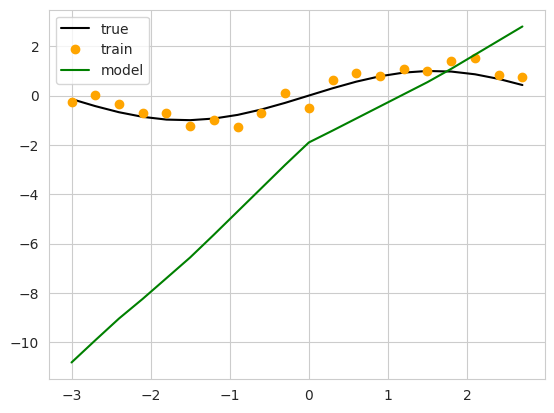

In [11]:
preds = [mlp.forward(x_i).squeeze() for x_i in train_x]


plt.close('all')
plt.plot(train_x.squeeze(), np.sin(train_x.squeeze()), '-', color='black', label='true')
plt.plot(train_x.squeeze(), train_y.squeeze(), 'o', color='orange', label='train')
plt.plot(train_x.squeeze(), preds, '-', color='green', label='model')
plt.legend()
plt.show()

  3%|▎         | 141/5000 [00:00<00:09, 489.47it/s]

100%|██████████| 5000/5000 [00:16<00:00, 296.28it/s]


loss nas primeiras epocas: [np.float64(1187.1940062447852), np.float64(10.864177349081091), np.float64(3.897476501574395), np.float64(2.7181509768862564), np.float64(2.396308398145576)]
loss nas ultimas epocas: [np.float64(1.2829353081351071), np.float64(1.2747858395190088), np.float64(1.2667603196312303), np.float64(1.2588546448655318), np.float64(1.2510649275798167)]


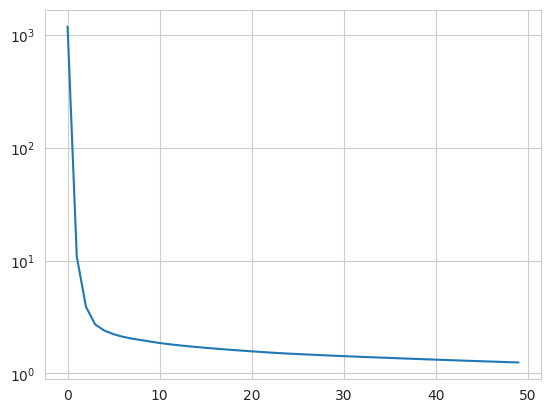

In [12]:
from tqdm import tqdm

# hiperparametros
history = []
lr = 1e-3
n_epochs = 5000
n_hidden_neurons = 32
# act_fn = np.tanh
# act_grad_fn = tanh_grad

act_fn = relu
act_grad_fn = relu_grad

# restart the training from scratch
# if the cell is executed more than once
mlp = Mlp(act_fn, act_grad_fn, n_hidden_neurons)
mlp.reset()

for epoch in tqdm(range(n_epochs)):
    preds = []

    # reseta os gradientes para zero
    mlp.zero_grad()

    for x_i, y_i in zip(train_x, train_y):
        pred_y = mlp.forward(x_i)
        mlp.backward(x_i, y_i, len(train_x))
        preds.append(pred_y)

    mlp.update(lr=lr)

    if epoch % 100 == 0:
        preds = np.array(preds)
        assert preds.shape == train_y.shape
        error = np.sum(np.square(preds - train_y))
        history.append(error)

print("loss nas primeiras epocas:", history[:5])
print("loss nas ultimas epocas:", history[-5:])
plt.plot(history)
plt.yscale('log')


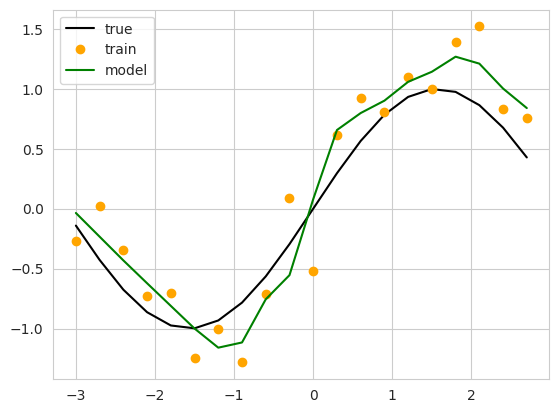

In [13]:
preds = np.array([mlp.forward(x) for x in train_x])


plt.close('all')
plt.plot(train_x.squeeze(), np.sin(train_x.squeeze()), '-', color='black', label='true')
plt.plot(train_x.squeeze(), train_y.squeeze(), 'o', color='orange', label='train')
plt.plot(train_x.squeeze(), preds.squeeze(), '-', color='green', label='model')
plt.legend()
plt.show()

In [14]:
preds = np.array([mlp.forward(np.array([[x]])) for x in train_x])
preds = preds.squeeze()

diffs = np.square(preds - train_y)
error = np.sum(diffs)
error

np.float64(602.2427717744172)

In [15]:
preds = np.array([mlp.forward(np.array([[x]])) for x in test_x])
preds = preds.squeeze()

diffs = np.square(preds - test_y)
error = np.sum(diffs)
error

np.float64(943.8638523368077)

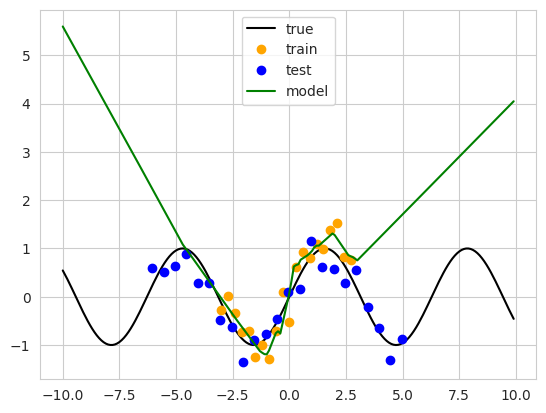

In [16]:
all_x = np.arange(-10.0, 10.0, 0.1)
all_x = all_x.reshape((len(all_x), 1, 1))

preds = np.array([mlp.forward(np.array(x)) for x in all_x])

plt.close('all')
plt.plot(all_x.squeeze(), np.sin(all_x.squeeze()), '-', color='black', label='true')
plt.plot(train_x.squeeze(), train_y.squeeze(), 'o', color='orange', label='train')
plt.plot(test_x.squeeze(), test_y.squeeze(), 'o', color='blue', label='test')
plt.plot(all_x.squeeze(), preds.squeeze(), '-', color='green', label='model')
plt.legend()
plt.show()

## Implementação da MLP - Versão Matricial

In [17]:

class MlpMatricial:
    def __init__(self, activation_fn, activation_grad_fn, n_hidden):
        self._activation_fn = activation_fn
        self._activation_grad_fn = activation_grad_fn
        self._n_hidden = n_hidden
        self.reset()
        self.zero_grad()

    def reset(self):
        self._w0 = np.random.normal(size=(self._n_hidden, 1))
        self._b0 = np.random.normal(size=(self._n_hidden, 1))
        self._w1 = np.random.normal(size=(1, self._n_hidden))
        self._b1 = np.random.normal(size=(1, 1))

    def zero_grad(self):
        self._grad_w0 = np.zeros_like(self._w0)
        self._grad_b0 = np.zeros_like(self._b0)
        self._grad_w1 = np.zeros_like(self._w1)
        self._grad_b1 = np.zeros_like(self._b1)

    def forward(self, x):
        # first layer
        self._z0 = np.matmul(self._w0, x) + self._b0
        self._h0 = self._activation_fn(self._z0)
        # second layer
        self._z1 = np.matmul(self._w1, self._h0) + self._b1
        self._y = self._z1 # without activation_fn

        return self._y

    def backward(self, x_i, y_i_hat, N):
        # d loss / d n1
        dloss_dy = (1 / N) * 2 * (self._y - y_i_hat)   # shape: [n_outs, 1]

        # gradient of last layer
        self._grad_w1 += dloss_dy @ self._h0.T  # shape: [n_outs, 1] x [1, n_hidden] = [n_outs, n_hidden]
        self._grad_b1 += dloss_dy   # shape: [n_outs, 1]

        # gradient of first layer
        dloss_dh = self._w1.T @ dloss_dy   # [n_hidden, n_outs] x [n_outs, 1] = [n_hidden, 1]
        # print("dloss_dh:", dloss_dh.shape)
        dloss_dz0 = self._activation_grad_fn(self._z0) * dloss_dh    # [n_hidden, 1]
        # print("dloss_dz0:", dloss_dz0.shape)
        # print("x:", x.shape)
        dloss_dw0 = dloss_dz0 @ x_i.T  # # [n_hidden, 1] x [1, n_ins] = [n_hidden, n_ins]
        # print("dloss_dw0:", dloss_dw0.shape)

        # delta = (self._w1.T @ dloss_dy) * self._activation_grad_fn(self._z0)  # (10,1)
        # self._grad_w0 += delta * x  # x é escalar
        self._grad_w0 += dloss_dw0
        self._grad_b0 += dloss_dz0

        #self._grad_w0 += dloss_dy * self._w1.T * sigmoid_grad(self._z0) * x
        #self._grad_b0 += dloss_dy * self._w1.T * sigmoid_grad(self._z0)

    def update(self, lr):
        self._w0 -= lr * self._grad_w0
        self._b0 -= lr * self._grad_b0
        self._w1 -= lr * self._grad_w1
        self._b1 -= lr * self._grad_b1

mlp = MlpMatricial(relu, relu_grad, 2)
mlp

  0%|          | 244/50000 [00:00<00:20, 2426.45it/s]

100%|██████████| 50000/50000 [00:23<00:00, 2101.80it/s]


loss nas primeiras epocas: [np.float64(563.6741929606039), np.float64(29.8693766255799), np.float64(12.999535333956233), np.float64(6.0766063460052955), np.float64(3.270968308867216)]
loss nas ultimas epocas: [np.float64(0.875986277189702), np.float64(0.8756787870457983), np.float64(0.8753714831112223), np.float64(0.8750643644159816), np.float64(0.8747574299961398)]


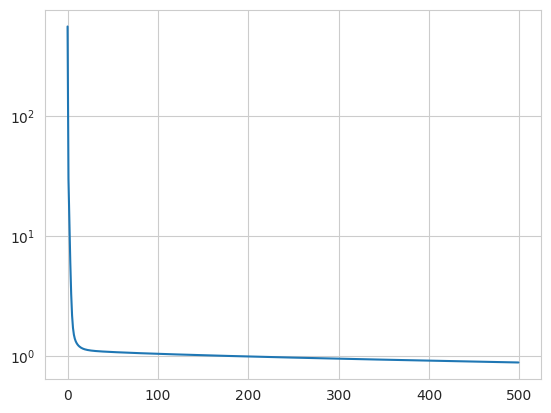

In [18]:
from tqdm import tqdm

# hiperparametros
history = []
lr = 1e-3
n_epochs = 50000
n_hidden_neurons = 32
act_fn = np.tanh
act_grad_fn = tanh_grad

# restart the training from scratch
# if the cell is executed more than once
mlp = MlpMatricial(act_fn, act_grad_fn, n_hidden_neurons)
mlp.reset()

for epoch in tqdm(range(n_epochs)):
    preds = []

    # reseta os gradientes para zero
    mlp.zero_grad()

    for x_i, y_i in zip(train_x, train_y):
        pred_y = mlp.forward(x_i)
        mlp.backward(x_i, y_i, len(train_x))
        preds.append(pred_y)

    mlp.update(lr=lr)

    if epoch % 100 == 0:
        preds = np.array(preds)
        assert preds.shape == train_y.shape
        error = np.sum(np.square(preds - train_y))
        history.append(error)

print("loss nas primeiras epocas:", history[:5])
print("loss nas ultimas epocas:", history[-5:])
plt.plot(history)
plt.yscale('log')


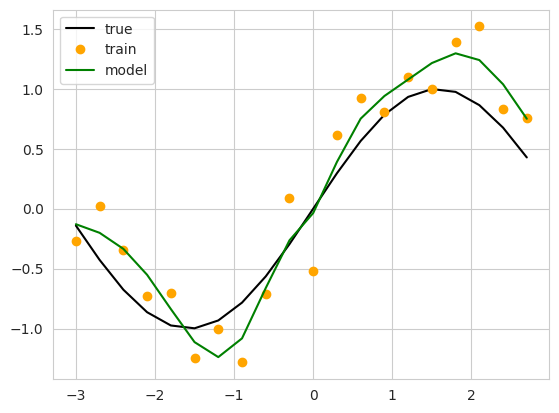

In [19]:
preds = np.array([mlp.forward(x) for x in train_x])


plt.close('all')
plt.plot(train_x.squeeze(), np.sin(train_x.squeeze()), '-', color='black', label='true')
plt.plot(train_x.squeeze(), train_y.squeeze(), 'o', color='orange', label='train')
plt.plot(train_x.squeeze(), preds.squeeze(), '-', color='green', label='model')
plt.legend()
plt.show()

Diferença de Tempo com uso de Matricial ou Loop

In [20]:
from time import time

n_hidden_neurons = 64
mlp_loop = Mlp(act_fn, act_grad_fn, n_hidden_neurons)
mlp_mat = MlpMatricial(act_fn, act_grad_fn, n_hidden_neurons)

start = time()

for epoch in tqdm(range(100)):
    mlp_loop.zero_grad()
    for x_i, y_i in zip(train_x, train_y):
        pred_y = mlp_loop.forward(x_i)
        mlp_loop.backward(x_i, y_i, len(train_x))

dt_loop = time() - start
print("Tempo (loop): ", dt_loop)

start = time()

for epoch in tqdm(range(100)):
    mlp_mat.zero_grad()
    for x_i, y_i in zip(train_x, train_y):
        pred_y = mlp_mat.forward(x_i)
        mlp_mat.backward(x_i, y_i, len(train_x))

dt_mat = time() - start
print("Tempo (matrix): ", dt_mat)

print("Speed up:", dt_loop / dt_mat)

100%|██████████| 100/100 [00:00<00:00, 182.91it/s]


Tempo (loop):  0.5500869750976562


100%|██████████| 100/100 [00:00<00:00, 2055.00it/s]

Tempo (matrix):  0.05339646339416504
Speed up: 10.301936497872397
